In [ ]:
!apt-get install openjdk-8-jdk-headless

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 42 not upgraded.
Need to get 36.5 MB of archives.
After this operation, 143 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u312-b07-0ubuntu1~18.04 [28.2 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jdk-headless amd64 8u312-b07-0ubuntu1~18.

In [ ]:
!wget https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz

--2022-05-19 02:41:39--  https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 138.201.131.134, 2a01:4f8:172:2ec5::2
Connecting to archive.apache.org (archive.apache.org)|138.201.131.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 272637746 (260M) [application/x-gzip]
Saving to: ‘spark-3.2.1-bin-hadoop2.7.tgz’

spark-3.2.1-bin-had 100%[===================>] 260.01M  26.6MB/s    in 10s     

2022-05-19 02:41:50 (25.7 MB/s) - ‘spark-3.2.1-bin-hadoop2.7.tgz’ saved [272637746/272637746]



In [ ]:
!tar xf /content/spark-3.2.1-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
findspark.find()

'/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
import pyspark
import numpy as np
import pandas as pd

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('Customer_Segmants').getOrCreate()
# Read data from CSV file
team_df=spark.read.csv('TeamClicks.csv', header=True, inferSchema=True)
team_df.show(5)

+------+------------+-------------+
|teamId|adClickCount|buyClickCount|
+------+------------+-------------+
|     2|         168|           29|
|     8|         218|           32|
|     9|         427|           98|
|    11|         309|           64|
|    13|         301|           55|
+------+------------+-------------+
only showing top 5 rows



In [ ]:
team_df.printSchema()

root
 |-- teamId: integer (nullable = true)
 |-- adClickCount: integer (nullable = true)
 |-- buyClickCount: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType,IntegerType
team_df = team_df.withColumn("teamId",col("teamId").cast(StringType())) \
    .withColumn("adClickCount",col("adClickCount").cast(IntegerType())) \
    .withColumn("buyClickCount",col("buyClickCount").cast(IntegerType()))
team_df.printSchema()

root
 |-- teamId: string (nullable = true)
 |-- adClickCount: integer (nullable = true)
 |-- buyClickCount: integer (nullable = true)



In [ ]:
team_df=team_df.na.drop()

In [ ]:
from pyspark.ml.feature import VectorAssembler
team_df.columns
assemble=VectorAssembler(inputCols=[
 'adClickCount', 'buyClickCount'], outputCol='features')
assembled_data=assemble.transform(team_df)
assembled_data.show(2)

+------+------------+-------------+------------+
|teamId|adClickCount|buyClickCount|    features|
+------+------------+-------------+------------+
|     2|         168|           29|[168.0,29.0]|
|     8|         218|           32|[218.0,32.0]|
+------+------------+-------------+------------+
only showing top 2 rows



In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(5)

+------+------------+-------------+------------+--------------------+
|teamId|adClickCount|buyClickCount|    features|        standardized|
+------+------------+-------------+------------+--------------------+
|     2|         168|           29|[168.0,29.0]|[1.12722539156150...|
|     8|         218|           32|[218.0,32.0]|[1.46270913905004...|
|     9|         427|           98|[427.0,98.0]|[2.86503120355214...|
|    11|         309|           64|[309.0,64.0]|[2.07328955947918...|
|    13|         301|           55|[301.0,55.0]|[2.01961215988102...|
+------+------------+-------------+------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)
    #print("Silhouette Score:",score)
    print(f"Silhouette Score for {i} clusters:",round(score, 2))

Silhouette Score for 2 clusters: 0.85
Silhouette Score for 3 clusters: 0.78
Silhouette Score for 4 clusters: 0.76
Silhouette Score for 5 clusters: 0.72
Silhouette Score for 6 clusters: 0.74
Silhouette Score for 7 clusters: 0.71
Silhouette Score for 8 clusters: 0.63
Silhouette Score for 9 clusters: 0.66


Text(0, 0.5, 'cost')

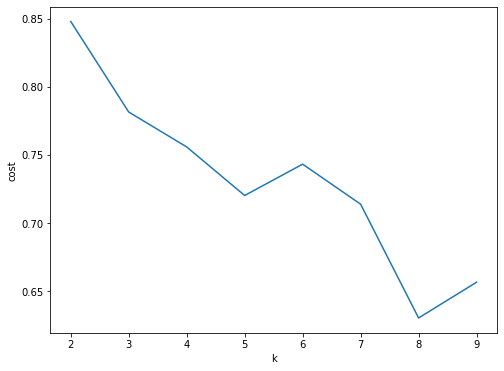

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
KMeans_=KMeans(featuresCol='features', k=2) 
KMeans_Model=KMeans_.fit(data_scale_output)
KMeans_Assignments=KMeans_Model.transform(data_scale_output)

centers = KMeans_Model.clusterCenters()
centers

KMeans_Assignments.show(10)

+------+------------+-------------+-------------+--------------------+----------+
|teamId|adClickCount|buyClickCount|     features|        standardized|prediction|
+------+------------+-------------+-------------+--------------------+----------+
|     2|         168|           29| [168.0,29.0]|[1.12722539156150...|         0|
|     8|         218|           32| [218.0,32.0]|[1.46270913905004...|         0|
|     9|         427|           98| [427.0,98.0]|[2.86503120355214...|         1|
|    11|         309|           64| [309.0,64.0]|[2.07328955947918...|         1|
|    13|         301|           55| [301.0,55.0]|[2.01961215988102...|         1|
|    18|         453|           78| [453.0,78.0]|[3.03948275224619...|         1|
|    20|         300|           60| [300.0,60.0]|[2.01290248493125...|         1|
|    22|         462|           86| [462.0,86.0]|[3.09986982679412...|         1|
|    25|         210|           42| [210.0,42.0]|[1.40903173945187...|         0|
|    27|        

In [ ]:

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="prediction")
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)


In [ ]:
pca_transformed

DataFrame[teamId: string, adClickCount: int, buyClickCount: int, features: vector, standardized: vector, prediction: vector]

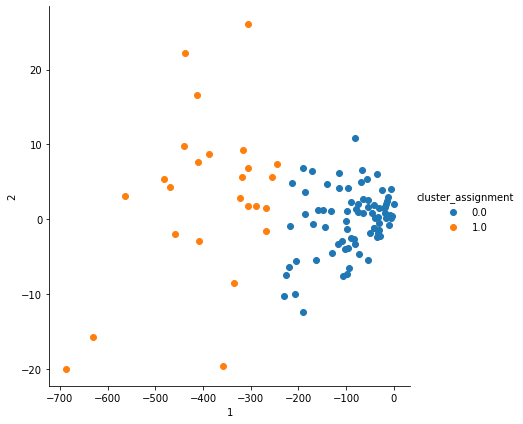

In [ ]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.prediction).collect())
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1","2", "cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1', '2' ).add_legend()


plt.show()

In [ ]:
df9= pd.DataFrame(KMeans_Assignments.collect())
df9.columns =['teamId', 'adClickCount', 'buyClickCount', 'features','standardized','prediction']
import matplotlib.pyplot as plt

groups = df9.groupby('prediction')
for name, group in groups:
    plt.plot(group.adClickCount, group.buyClickCount, marker='o', linestyle='', markersize=8, label=name)
[plt.text(x=row['adClickCount'], y=row['buyClickCount'], s=row['teamId'],alpha=0.7,fontsize=9) for k,row in df9.iterrows()]
plt.legend()